# Финальный проект: исследование данных сервиса Яндекс Афиша

* **Автор:** Ксенофонтов Никита
* **Дата:** 21.09.2025

### Цели и задачи проекта

**Цель:** провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

**Задачи:**
1. Загрузка данных и знакомство с ними
2. Предобработка данных и подготовка их к исследованию
3. Исследовательский анализ данных
4. Статистический анализ данных
5. Общий вывод и рекомендации

### Описание данных
Для анализа было предоставлено 3 датасета:

Первый датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных:


* `order_id` — уникальный идентификатор заказа.
* `user_id` — уникальный идентификатор пользователя.
* `created_dt_msk` — дата создания заказа (московское время).
* `created_ts_msk` — дата и время создания заказа (московское время).
* `event_id` — идентификатор мероприятия из таблицы events.
* `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение `нет`.
* `age_limit` — возрастное ограничение мероприятия.
* `currency_code` — валюта оплаты, например rub для российских рублей.
* `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
* `revenue` — выручка от заказа.
* `service_name` — название билетного оператора.
* `tickets_count` — количество купленных билетов.
* `total` — общая сумма заказа.
* `days_since_prev` — количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия:

* `event_id` — уникальный идентификатор мероприятия.
* `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
* `event_type_description` — описание типа мероприятия.
* `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
* `organizers` — организаторы мероприятия.
* `region_name` — название региона.
* `city_name` — название города.
* `venue_id` — уникальный идентификатор площадки.
* `venue_name` — название площадки.
* `venue_address` — адрес площадки.

Третий датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:

* `nominal` — номинал (100 тенге).
* `data` — дата.
* `curs` — курс тенге к рублю.
* `cdx` — обозначение валюты (kzt).

### Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Предобработка данных и подготовка их к исследованию
3. Исследовательский анализ данных
4. Статистический анализ данных
5. Общий вывод и рекомендации

## Загрузка данных и знакомство с ними

In [1]:
#Импортируем библиотеки
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import ttest_ind
    from statsmodels.stats.power import NormalIndPower
    from statsmodels.stats.proportion import proportion_effectsize
    from statsmodels.stats.proportion import proportions_ztest
except ImportError as e:
    print(f'Ошибка при импорте библиотеки: {e}') 

In [2]:
#Увеличим макс. кол-во отображения строк
pd.set_option('display.max_rows', 100)

In [3]:
#Создадим датафреймы
df_orders = pd.read_csv('/datasets/final_tickets_orders_df.csv')
df_events = pd.read_csv('/datasets/final_tickets_events_df.csv')
df_tenge = pd.read_csv('/datasets/final_tickets_tenge_df.csv')

In [4]:
#Выведем информацию о датафрейме df_orders
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [5]:
#Выведем несколько строк
df_orders.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


Столбцы c датой имеют тип `object`, необходимо изменить тип данных на более подходящий.

In [6]:
#Изменим тип данных столба
df_orders['created_dt_msk'] = pd.to_datetime(df_orders['created_dt_msk'])
df_orders['created_ts_msk'] = pd.to_datetime(df_orders['created_ts_msk'])

In [7]:
#Выведем информацию о датафрейме df_events
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [8]:
#Выведем несколько строк
df_events.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


В данном датафрейме пропуски отсутствуют, типы данных столбцов верны.

In [9]:
#Выведем информацию df_tenge
df_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [10]:
#Выведем несколько строк
df_tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [11]:
df_tenge['data'] = pd.to_datetime(df_tenge['data'])

В датафрейме `df_tenge` пропуски так же отсутствуют, типы данных столбцов верны.

Познакомившись с данными, можем сделать несколько выводов:
* В датафреймах `df_events` и `df_tenge` столбцы с датой имели неверный тип данных
* В столбцах отсутвуют пропуски, кроме столбца `days_since_prev`, где это обосновано
* Данные соответствуют описанию
* Для оптимизации есть возможность снижения размерности количественных данных.

## Предобработка данных и подготовка их к исследованию

In [12]:
#Изучим уникальные категориальные значения df_orders
for column in ['cinema_circuit', 'currency_code', 'age_limit', 'device_type_canonical']:
    print(df_orders[column].unique())

['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']
['rub' 'kzt']
[16  0 18 12  6]
['mobile' 'desktop']


In [13]:
for column in ['event_type_description', 'event_type_main']:
    print(df_events[column].unique())

['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
 'цирковое шоу' 'событие' 'фестиваль' 'спортивное мероприятие' 'выставка'
 'спорт' 'оперетта' 'экскурсия' 'рок-мюзикл' 'музыкальный спектакль'
 'снегурочка' 'подарок' 'кукольный спектакль']
['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']


В уникальных категориальных значениях аномалий не замечено.

In [14]:
df_orders.revenue.describe()

count    290849.000000
mean        625.083054
std        1227.316214
min         -90.760000
25%         116.790000
50%         355.340000
75%         809.750000
max       81174.540000
Name: revenue, dtype: float64

In [15]:
df_orders[df_orders['revenue'] < 0].shape[0]

381

Можем заметить отрицательные значения в выручке. Мы не знаем, причину таких значений, поэтому 381 строку мы можем исключить из исследования, так как глобально не повлияет на результат исследований.

In [16]:
df_orders = df_orders[df_orders['revenue'] > 0]

<AxesSubplot:>

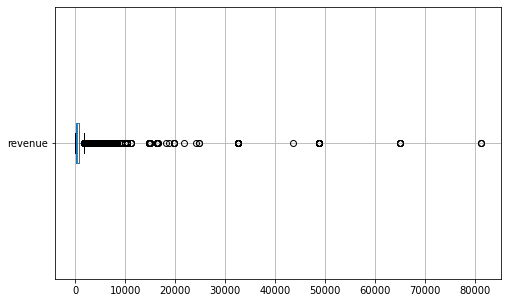

In [17]:
#Проверим на выбросы столбец revenue
df_orders[df_orders.currency_code == 'rub'].boxplot(column='revenue', vert=False, figsize=(8,5))

Можем заметить большое количество выбросов, отберём значения по 99-му процентилю.

<AxesSubplot:>

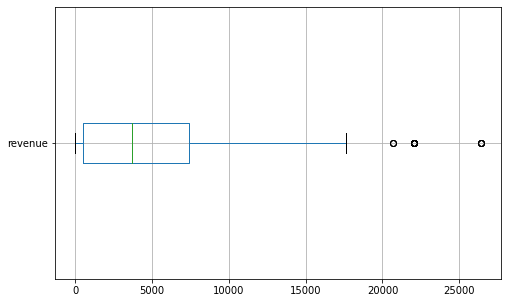

In [18]:
df_orders[df_orders.currency_code == 'kzt'].boxplot(column='revenue', vert=False, figsize=(8,5))

In [19]:
#Количество строк до обработки
count_before = df_orders.shape[0]

#Разделяем датафрейм по валютам
rub_df = df_orders[df_orders.currency_code == 'rub']
kzt_df = df_orders[df_orders.currency_code == 'kzt']

#Вычисляем 99-й процентиль для каждой валюты
rub_quantile = rub_df.revenue.quantile(0.99)
kzt_quantile = kzt_df.revenue.quantile(0.99)
tickets_quantile = df_orders.tickets_count.quantile(0.99)

#Фильтруем выбросы для каждой валюты
rub_filtered = rub_df[(rub_df.revenue <= rub_quantile) & (rub_df.tickets_count <= tickets_quantile)]
kzt_filtered = kzt_df[(kzt_df.revenue <= kzt_quantile) & (kzt_df.tickets_count <= tickets_quantile)]

#Объединяем результаты
df_orders = pd.concat([rub_filtered, kzt_filtered], ignore_index=True)

#Заопмним сколько строк было отфильтровано
quant_count = count_before - df_orders.shape[0]

In [20]:
print(f'Количество отфильтрованных выбросов: {quant_count}')

Количество отфильтрованных выбросов: 2999


<AxesSubplot:>

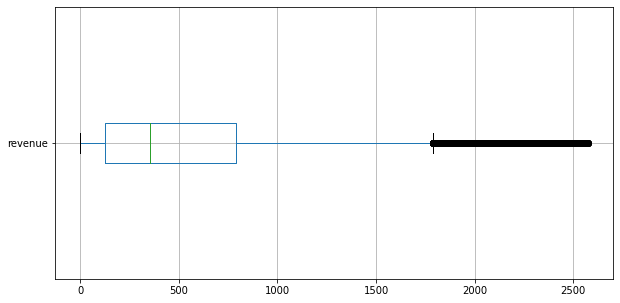

In [21]:
#Проверим на выбросы столбцы revenue
df_orders[df_orders.currency_code == 'rub'].boxplot(column='revenue', vert=False, figsize=(10,5))

<AxesSubplot:>

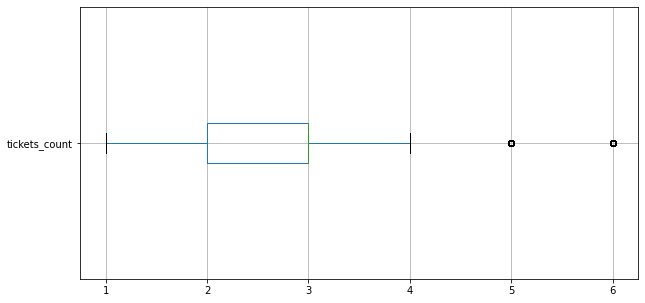

In [22]:
#Проверим на выбросы столбец tickets_count
df_orders.boxplot(column='tickets_count', vert=False, figsize=(10,5))

Проверим явные и неявные дубликаты:

In [23]:
#Проверяем датасеты на полные дубликаты
for df in [df_orders, df_events, df_tenge]:
   dup_sum = df.duplicated().sum()
   print(f'Количество дубликатов {dup_sum}') 

Количество дубликатов 0
Количество дубликатов 0
Количество дубликатов 0


In [24]:
#Получаем список всех столбцов
all_columns = df_orders.columns.tolist()

#Указываем столбец, который не нужно проверять
exclude_column = 'order_id'

#Создаем список столбцов для проверки
columns_to_check = [col for col in all_columns if col != exclude_column]

#Находим дубликаты
duplic_count_orders = df_orders.duplicated(subset=columns_to_check, keep=False).sum()

print('Количество неполных дубликатов в df_orders:')
print(duplic_count_orders)

#Фильтруем строки
df_orders = df_orders[~df_orders.duplicated(subset=columns_to_check, keep=False)]

Количество неполных дубликатов в df_orders:
56


Было найдено 58 неполных дубликатов в `df_orders`, с помощью фильтра исключим их из датафрейма, так как они искажают данные.

In [25]:
#Получаем список всех столбцов
all_columns = df_events.columns.tolist()

#Указываем столбец, который не нужно проверять
exclude_column = 'event_id'

#Создаем список столбцов для проверки
columns_to_check = [col for col in all_columns if col != exclude_column]

#Находим дубликаты
duplic_count_events = df_events.duplicated(subset=columns_to_check, keep=False).sum()

print('Количество неполных дубликатов в df_events:')
print(duplic_count_events)

Количество неполных дубликатов в df_events:
1513


В df_events так же было найдено 1513 неполных дубликатов. Но удалив эти строки, мы потеряем много данных о заказах, лучше оставить как есть.

Понизим разрядности целочисленных и float столбцов для оптимизации

In [26]:
#Для df_orders
for col in df_orders.select_dtypes(include=['int64']).columns:
    df_orders[col] = pd.to_numeric(df_orders[col], downcast='integer')
for col in df_orders.select_dtypes(include=['float64']).columns:
    df_orders[col] = df_orders[col].astype('float32')

In [27]:
#Проверяем результат
df_orders.dtypes

order_id                          int32
user_id                          object
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
event_id                          int32
cinema_circuit                   object
age_limit                          int8
currency_code                    object
device_type_canonical            object
revenue                         float32
service_name                     object
tickets_count                      int8
total                           float32
days_since_prev                 float32
dtype: object

In [28]:
#Для df_events
for col in df_events.select_dtypes(include=['int64']).columns:
    df_events[col] = pd.to_numeric(df_events[col], downcast='integer')
for col in df_events.select_dtypes(include=['float64']).columns:
    df_events[col] = df_events[col].astype('float32')

In [29]:
df_events.dtypes

event_id                   int32
event_name                object
event_type_description    object
event_type_main           object
organizers                object
region_name               object
city_name                 object
city_id                    int32
venue_id                   int16
venue_name                object
venue_address             object
dtype: object

Добавим несколько новых столбцов в `df_orders`

In [30]:
# Объединяем датафреймы по дате
df_orders = pd.merge(
    left=df_orders,
    right=df_tenge[['data', 'curs']],
    left_on='created_dt_msk',
    right_on='data',
    how='left'
)

# Рассчитываем revenue_rub
df_orders.loc[df_orders.currency_code == 'kzt', 'revenue_rub'] = df_orders['revenue'] * df_orders['curs'] / 100
df_orders.loc[df_orders.currency_code == 'rub', 'revenue_rub'] = df_orders['revenue']

In [31]:
#Удалим лишние столбцы
df_orders.drop(['data', 'curs'], axis=1, inplace=True)

In [32]:
#Рассчитаем цену одного билета
df_orders['one_ticket_revenue_rub'] = np.where(
    df_orders['tickets_count'] > 0,
    df_orders['revenue_rub'] / df_orders['tickets_count'],
    np.nan
)

In [33]:
#Выделим месяц заказа в отдельный столбец
df_orders['month'] = df_orders['created_dt_msk'].dt.month

In [34]:
#Добавим столбец обозначающий сезон даты
conditions = [
    df_orders['month'].isin([12, 1, 2]),
    df_orders['month'].isin([3, 4, 5]),
    df_orders['month'].isin([6, 7, 8]),
    df_orders['month'].isin([9, 10, 11])
]

choices = ['зима', 'весна', 'лето', 'осень']

df_orders['season'] = np.select(conditions, choices)

В ходе предобработки были выполнены следующие шаги:
* Были отсеяны выбросы по выручке и кол-ву билетов, 3067 строк
* Отсеяли 58 неполных дубликатов в `df_orders` и 1513 неполных дубликатов в `df_events`
* Оптимизировали разрядность типов данных датафреймов
* Добавили несколько новых столбцов для удобства работы:
    * `revenue_rub` — выручка в российских рублях
    * `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие.
    * `month` — месяц оформления заказа
    * `season` — информация о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

Для каждого месяца найдём количество заказов и визуализируем результаты. Проверим, фиксируется ли увеличение заказов от июня к ноябрю 2024 года.

In [35]:
#Добавим столбцы из df_events, которые пригодятся далее
df_work = df_orders.merge(
    df_events[['event_type_main', 'region_name', 'event_id']],
    on='event_id',
    how='inner'
)

In [36]:
#Создадим сводную таблицу типов мероприятий
pivot_event_orders = pd.pivot_table(
    df_work,
    index='month',
    columns='event_type_main',
    values='order_id',
    aggfunc='count'
)

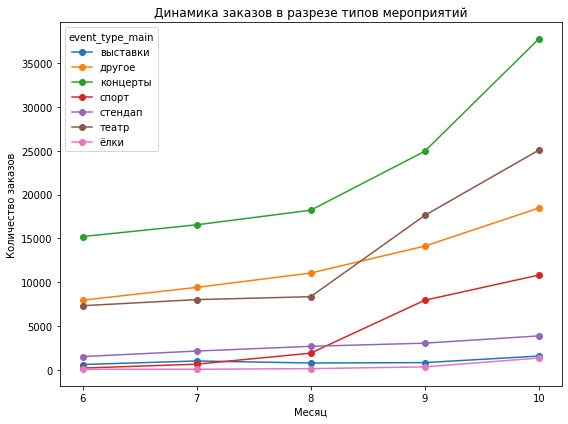

In [37]:
#Построим линейный график
pivot_event_orders.plot(
    kind='line',
    marker ='o',
    figsize=(8,6)
)

plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов в разрезе типов мероприятий')
plt.xticks(pivot_event_orders.index)
plt.tight_layout()
plt.show()

In [38]:
# Рассчитываем рост между месяцами
growth = pivot_event_orders.pct_change(axis=0) * 100

print("Динамика роста по месяцам (в %):")
print(growth)

Динамика роста по месяцам (в %):
event_type_main   выставки     другое   концерты       спорт    стендап  \
month                                                                     
6                      NaN        NaN        NaN         NaN        NaN   
7                66.776316  18.347586   8.821983  217.647059  41.424802   
8               -22.682446  17.405164  10.039870  194.444444  25.279851   
9                 5.484694  27.821522  36.934563  316.352201  13.440060   
10               90.447400  30.779579  51.419179   36.178248  27.207089   

event_type_main       театр        ёлки  
month                                    
6                       NaN         NaN  
7                  9.508197    1.515152  
8                  4.166667  108.955224  
9                111.053892  144.285714  
10                42.296998  294.152047  


In [39]:
#Создадим сводную таблицу девайсов
pivot_device_orders = pd.pivot_table(
    df_work,
    index='month',
    columns='device_type_canonical',
    values='order_id',
    aggfunc='count'
)

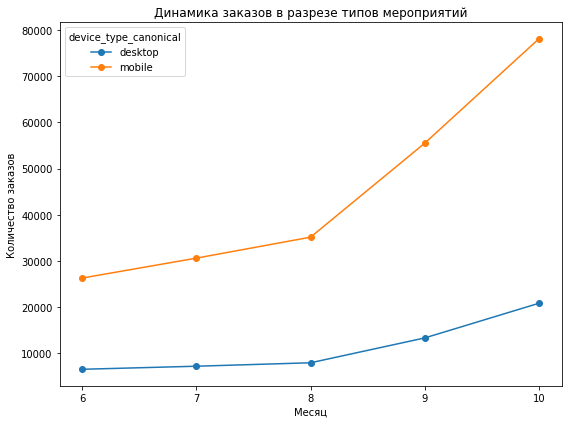

In [40]:
#Построим линейный график
pivot_device_orders.plot(
    kind='line',
    marker='o',
    figsize=(8,6)
)

plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов в разрезе типов мероприятий')
plt.xticks(pivot_device_orders.index)
plt.tight_layout()
plt.show()

In [41]:
# Рассчитываем рост между месяцами
growth = pivot_device_orders.pct_change(axis=0) * 100

print("Динамика роста по месяцам (в %):")
print(growth)

Динамика роста по месяцам (в %):
device_type_canonical    desktop     mobile
month                                      
6                            NaN        NaN
7                      10.106707  16.388023
8                      10.328119  14.798733
9                      67.461413  57.846093
10                     56.193331  40.690028


In [42]:
#Создадим сводную таблицу девайсов
pivot_age_orders = pd.pivot_table(
    df_work,
    index='month',
    columns='age_limit',
    values='order_id',
    aggfunc='count'
)

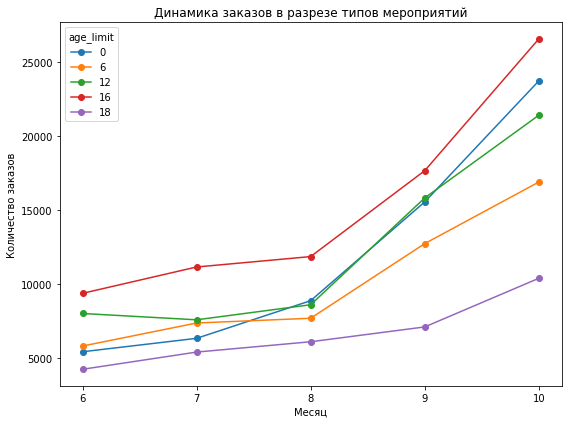

In [43]:
#Построим линейный график
pivot_age_orders.plot(
    kind='line',
    marker='o',
    figsize=(8,6)
)

plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов в разрезе типов мероприятий')
plt.xticks(pivot_age_orders.index)
plt.tight_layout()
plt.show()

In [44]:
# Рассчитываем рост между месяцами
growth = pivot_age_orders.pct_change(axis=0) * 100

print("Динамика роста по месяцам (в %):")
print(growth)

Динамика роста по месяцам (в %):
age_limit         0          6          12         16         18
month                                                           
6                NaN        NaN        NaN        NaN        NaN
7          16.706576  26.758383  -5.316361  18.967357  27.336944
8          40.119949   4.354904  13.391327   6.303802  12.888314
9          75.095742  65.496620  83.831222  48.916069  16.396396
10         52.550659  32.647290  35.289282  50.385182  46.200394


По типам мероприятий:

    Наибольший рост показывают:
        «стендап» (особенно в октябре — +27.2%)
        «театр» (пиковый рост в сентябре — +111%)
        «ёлки» (экспоненциальный рост к октябрю — +294%)

    Стабильный рост демонстрируют:
        «выставки» (в среднем +30% ежемесячно)
        «концерты» (постепенно растут, октябрь — +51%)

По устройствам:

    Мобильный трафик показывает более высокие темпы роста:
        В среднем +40-57% ежемесячно
        Пик в сентябре (+57.8%)

    Десктоп демонстрирует:
        Более умеренный рост
        Значительный скачок в сентябре (+67.4%)

По возрастным ограничениям:

    Самый активный рост в категории «0+»:
        Общий рост за период — +52.6%
        Пик в сентябре (+75%)

    Стабильное развитие показывают:
        Категория «16+» (около +50% в октябре)
        Категория «18+» (устойчивый рост +16-46%)

Промежуточные выводы:

Наблюдается общий тренд на рост по всем категориям.
Мобильный сегмент лидирует по темпам роста.
Сезонный фактор особенно заметен в категории «ёлки».
Возрастная категория 0+ показывает наибольший потенциал роста.
Концертная и театральная активность демонстрирует хорошие темпы развития.

**Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.**

In [45]:
#Разделим датафрейм на летний и осенний периоды
summer_df = df_work[df_work['season'] == 'лето']

autumn_df = df_work[df_work['season'] == 'осень']

In [46]:
#Рассчитаем доли для категорий летом
#Функция для расчета долей
def calculate_shares(df, column):
    return df[column].value_counts(normalize=True) * 100

#Расчет долей для летних и осенних данных
summer_shares = {
    'event_type': calculate_shares(summer_df, 'event_type_main'),
    'device': calculate_shares(summer_df, 'device_type_canonical'),
    'age_limit': calculate_shares(summer_df, 'age_limit')
}

autumn_shares = {
    'event_type': calculate_shares(autumn_df, 'event_type_main'),
    'device': calculate_shares(autumn_df, 'device_type_canonical'),
    'age_limit': calculate_shares(autumn_df, 'age_limit')
}

In [47]:
#Функция для построения графика
def plot_comparison(summer_data, autumn_data, title):
    plt.figure(figsize=(12, 6))
    
    #Объединение данных
    combined_data = pd.DataFrame({
        'Категория': summer_data.index,
        'Лето': summer_data.values,
        'Осень': autumn_data.values,
        'Разница (%)': summer_data.values - autumn_data.values
    })
    
    #Создание графика
    sns.barplot(
        data=combined_data.melt(id_vars='Категория'),
        x='Категория',
        y='value',
        hue='variable',
        palette='viridis',
        edgecolor='black',
        alpha=0.8
    ) 
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title(title, fontsize=14)
    plt.xlabel('Категория', fontsize=12)
    plt.ylabel('Доля, %', fontsize=12)
    plt.legend(title='Сезон', title_fontsize=12, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    #Добавляем значения над столбцами
    for p in plt.gca().patches:
        width = p.get_width()
        height = p.get_height()
        x = p.get_x() + width / 2
        y = p.get_y() + height * 1.01  # Смещение над столбцом
        plt.text(x, y, f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

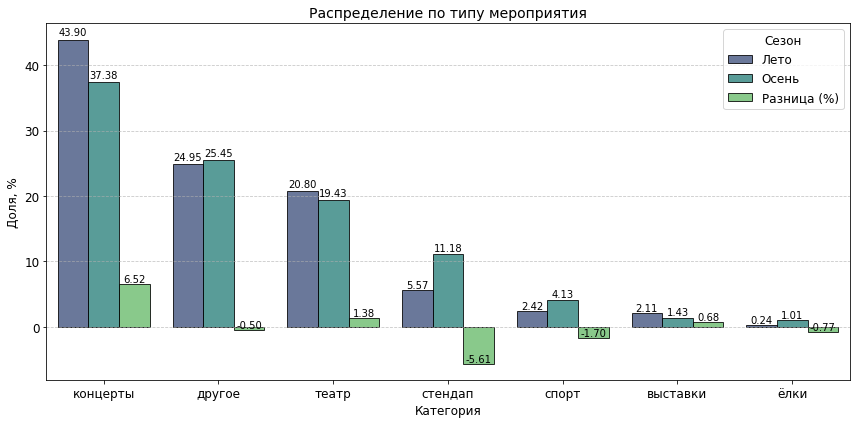

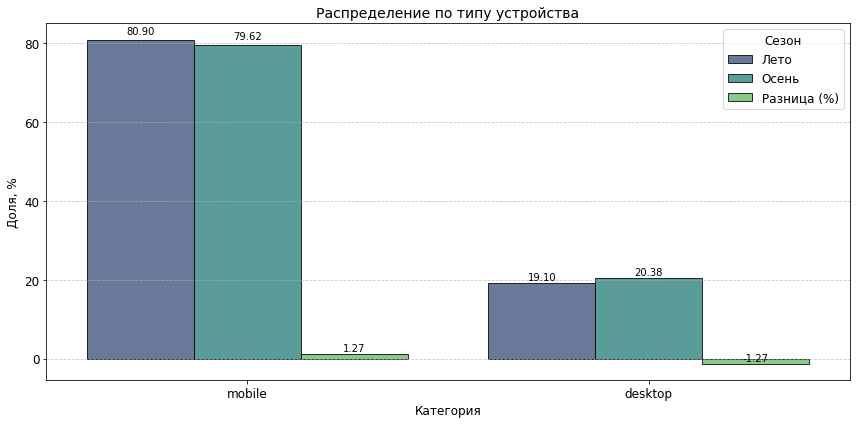

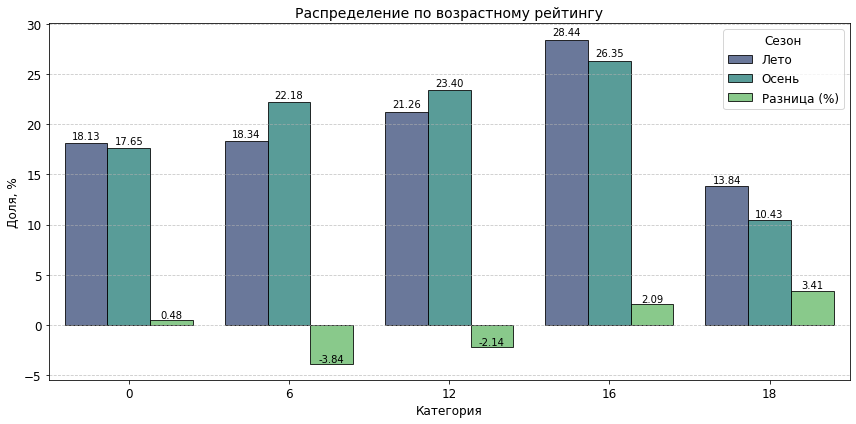

In [48]:
# Тип мероприятия
plot_comparison(
    summer_shares['event_type'],
    autumn_shares['event_type'],
    'Распределение по типу мероприятия'
)

# Тип устройства
plot_comparison(
    summer_shares['device'],
    autumn_shares['device'],
    'Распределение по типу устройства'
)

# Возрастной рейтинг
plot_comparison(
    summer_shares['age_limit'],
    autumn_shares['age_limit'],
    'Распределение по возрастному рейтингу'
)

Изучив графики можем увидить, что изменения по типу мероприятий следующие:
- Осенью снизилась доля концертов, театров и выставок. Но значительно выросла доля стендапов, спортивных мероприятий.

По типам устройств:
- Незначительно увеличилась доля стационарных устройств.

По возрастному рейтингу:
- Увеличилась доля мероприятий 6+ и 12+, но упала доля мероприятий 16+ и 18+.

**Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. Узнаем, видна ли динамика средней стоимости билета в разрезе разных категорий мероприятий.**

In [49]:
#Рассчитаем среднюю смоимость билета по типам мероприятий
summer_ticket = summer_df.groupby('event_type_main')['one_ticket_revenue_rub'].mean()
autumn_ticket = autumn_df.groupby('event_type_main')['one_ticket_revenue_rub'].mean()

In [50]:
#Создадим датафрейм с сезонными ценами на билет
seasons_data = pd.DataFrame({
    'Тип мероприятия': summer_ticket.index,
    'Ср. выручка билета летом': summer_ticket.values,
    'Ср. выручка билета осенью': autumn_ticket.values,
    'Разница (%)': (1 - (summer_ticket.values / autumn_ticket.values)) * 100
})

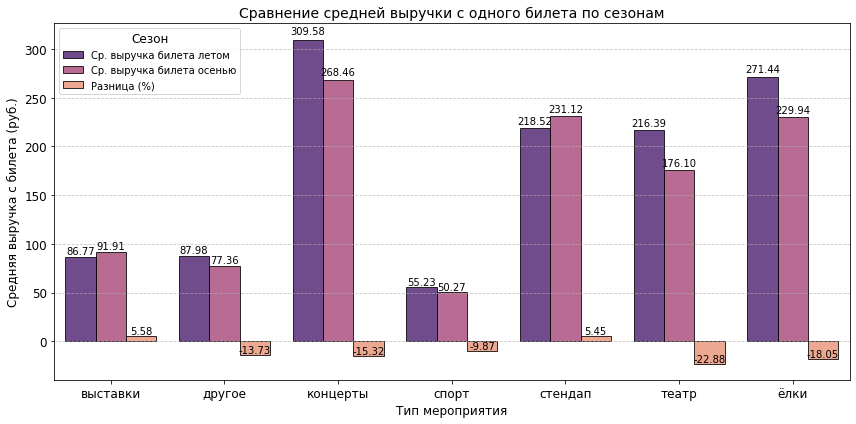

In [51]:
#Создадим столбчатый график
plt.figure(figsize=(12,6))

sns.barplot(
    data=seasons_data.melt(id_vars='Тип мероприятия'),
    x='Тип мероприятия',
    y='value',
    hue='variable',
    palette='magma',
    edgecolor='black',  # Добавляем обводку для лучшей читаемости
    alpha=0.8  # Прозрачность столбцов
)

plt.title('Сравнение средней выручки с одного билета по сезонам', fontsize=14)
plt.xlabel('Тип мероприятия', fontsize=12)
plt.ylabel('Средняя выручка с билета (руб.)', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Сезон', title_fontsize=12, fontsize=10)

#Добавляем значения над столбцами
for p in plt.gca().patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + height * 1.01  # Смещение над столбцом
    plt.text(x, y, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Общая тенденция показывает значительное снижение стоимости билетов осенью по большинству категорий мероприятий.

Наиболее существенное падение цен наблюдается в следующих категориях:

* Театральные представления (-22.88%)

* Новогодние мероприятия (“ёлки”) (-18.04%)

* Концертные программы (-15.32%)

Рост цен зафиксирован только в двух категориях:

* Стендапы (+5.45%)

* Выставки (+5.58%)

    Театральные мероприятия демонстрируют самое значительное снижение цен, что может быть связано с сезонным снижением спроса в дачный период

    Концерты также существенно теряют в цене, что характерно для осеннего периода, когда проходит меньше крупных гастролей

    Спортивные мероприятия показывают умеренное снижение (-9.87%), что может быть связано с окончанием активного летнего сезона

    Осенью происходит общее снижение среднего чека на билеты по большинству категорий, что характерно для непикового сезона

    Наибольшее снижение наблюдается в массовых форматах развлечений (театр, концерты, ёлки)

    Относительно стабильными остаются цены на выставки и стендап-шоу, что может говорить о более равномерном спросе на эти форматы в течение года

    Разброс изменений цен между категориями достаточно значителен (от -22.88% до +5.58%), что указывает на разную сезонность различных форматов развлечений

Концерты остаются лидером рынка, хотя их доля снижается с 43.89% до 37.38%. Это подтверждает их доминирующее положение на рынке развлечений.

Значительный рост показали:

* Стендапы (с 5.57% до 11.18%)

* Спортивные мероприятия (с 2.42% до 4.13%)

* Новогодние программы (с 0.24% до 1.01%)

Снижение доли рынка наблюдается у:

* Театральных представлений (с 20.80% до 19.43%)

* Выставок (с 2.11% до 1.43%)

* Концертных программ

### Осенняя активность пользователей

**Изучим активность пользователей осенью 2024 года.**
Проанализируем динамику изменений по дням для:
* общего числа заказов
* количества активных пользователей DAU
* среднего числа заказов на одного пользователя
* средней стоимости одного билета.

In [52]:
#Создадим сводную таблицу по дням
autumn_days = autumn_df.groupby('created_dt_msk').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean'
    }
)

#Переименуем столбцы для удобства
autumn_days = autumn_days.rename(
    columns={
        'order_id': 'count_orders',
        'user_id': 'DAU',
        'one_ticket_revenue_rub': 'avg_revenue_one_ticket'
    }
)

In [53]:
#Рассчитаем среднее кол-во заказов на пользователя
autumn_days['avg_count_orders'] = autumn_days['count_orders'] / autumn_days['DAU']

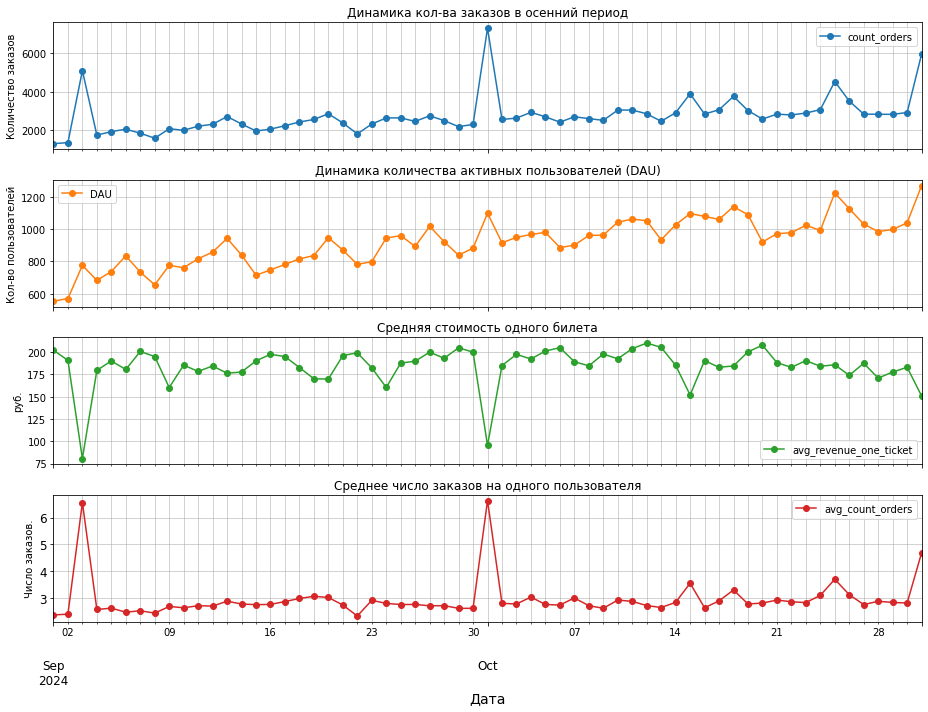

In [54]:
#Создадим подграфики
fig, axes = plt.subplots(
    nrows=4, 
    figsize=(13, 10),
    sharex=True,
    sharey=False
)

autumn_lines = autumn_days.plot(
    kind='line',
    marker='o',
    ax=axes,
    subplots=True,
    title=['Динамика кол-ва заказов в осенний период', 
           'Динамика количества активных пользователей (DAU)', 
           'Средняя стоимость одного билета', 
           'Cреднее число заказов на одного пользователя']
)

autumn_lines[0].set_ylabel('Количество заказов')
autumn_lines[1].set_ylabel('Кол-во пользователей')
autumn_lines[2].set_ylabel('руб.')
autumn_lines[3].set_ylabel('Число заказов.')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for ax in axes:
    ax.grid(which='both', alpha=0.7)

plt.xlabel('Дата', fontsize=14)

plt.tight_layout()
plt.show()

In [55]:
#Сгруппируем по месяцам средние показатели
monthly_stats = autumn_days.groupby(autumn_days.index.to_period('M')).mean()

#Рассчитаем разницу в относительных показателях
growth = (monthly_stats.iloc[1] - monthly_stats.iloc[0]) / monthly_stats.iloc[0] * 100

#Вывод результатов
print("Средние значения по месяцам:")
print(monthly_stats)

print("\nПроцентный рост:")
print(growth)

Средние значения по месяцам:
                count_orders          DAU  avg_revenue_one_ticket  \
created_dt_msk                                                      
2024-09          2295.000000   810.033333              183.409778   
2024-10          3191.419355  1024.516129              185.150987   

                avg_count_orders  
created_dt_msk                    
2024-09                 2.825005  
2024-10                 3.082256  

Процентный рост:
count_orders              39.059667
DAU                       26.478268
avg_revenue_one_ticket     0.949354
avg_count_orders           9.106239
dtype: float64


За анализируемый период (сентябрь-октябрь 2024) наблюдается существенный рост всех ключевых метрик:

* Количество заказов выросло на 39% (с 2295 до 3191 в день)

* Активные пользователи (DAU) увеличились на 26% (с 775 до 1045 в день)

* Средний чек показал незначительный рост — 0.9% (с 183.4 до 185.1 руб.)

* Конверсия (заказов на пользователя) выросла на 9% (с 2.82 до 3.08)

Наиболее заметный рост демонстрируют показатели заказов и пользователей, при этом средняя стоимость билета остается относительно стабильной. В октябре наблюдается общая тенденция к увеличению всех метрик, особенно ярко выраженная в конце месяца.

**Изучим недельную цикличность. Выделим день недели и сравним пользовательскую активность в будни и выходные.**

In [56]:
#Сгруппируем по дням недели активных пользователей
day_week = autumn_df.groupby(autumn_df['created_dt_msk'].dt.day_of_week + 1)['user_id'].nunique()

#Переименуем цифры в день недели
day_week.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

In [57]:
day_week

Пн    4432
Вт    4785
Ср    4808
Чт    4960
Пт    4843
Сб    4525
Вс    4343
Name: user_id, dtype: int64

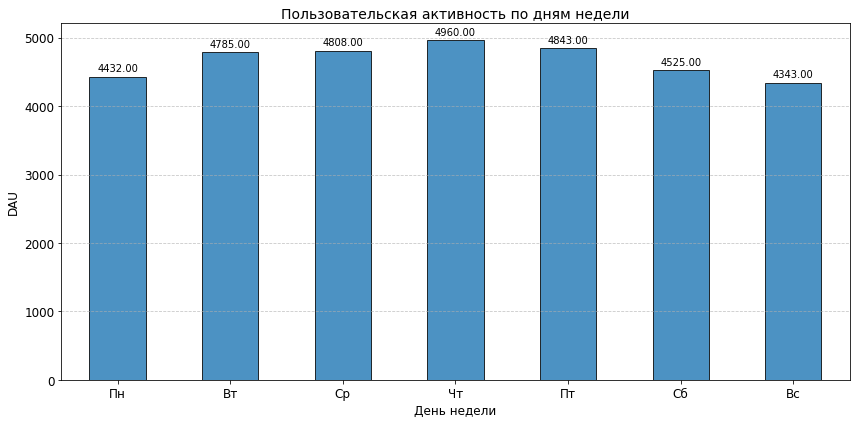

In [58]:
#Создадим столбчатую диаграмму
plt.figure(figsize=(12,6))

day_week.plot(
    kind='bar',
    legend=False,
    alpha=0.8,
    edgecolor='black',
)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
    
plt.title('Пользовательская активность по дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('DAU', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Добавляем значения над столбцами
for p in plt.gca().patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + height * 1.01  #Смещение над столбцом
    plt.text(x, y, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

На основе представленных данных можно выделить следующие ключевые значения:

* Максимальный DAU наблюдается в четверг (4960 пользователей)

* Минимальный DAU фиксируется в воскресенье (4343 пользователя)

* Средний показатель за неделю составляет около 4670 пользователей

* Наибольшая активность пользователей приходится на середину недели

* Наблюдается закономерное снижение активности к выходным

### Популярные события и партнёры

**Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. Узнаем, в каких регионах предлагается наибольшее разнообразие мероприятий.**

In [59]:
#Сгруппируем по регионам
region_group = df_work.groupby('region_name').agg(
    {
        'event_id': 'nunique',
        'order_id': 'count'
    })

#Переименовываем столбцы для удобства
region_group.columns = ['unique_events', 'total_orders']

#Рассчитываем общее количество мероприятий
total_events = region_group['unique_events'].sum()

#Добавляем столбец с долей мероприятий
region_group['event_share'] = round(region_group['unique_events'] / total_events * 100, 2)

#Результат отсортируем по доле мероприятий
region_group = region_group.sort_values(by='event_share', ascending=False)

In [60]:
#Выделим топ 7 регионов
region_group = region_group.iloc[:7]

In [61]:
region_group

,unique_events,total_orders,event_share
region_name,,,
Каменевский регион,5793,85374,26.33
Североярская область,3774,43469,17.15
Широковская область,1217,16082,5.53
Светополянский округ,1059,7462,4.81
Речиновская область,701,6265,3.19
Травяная область,667,4719,3.03
Горицветская область,551,5153,2.50


**Лидеры рынка**

Каменевский регион занимает абсолютное лидерство по всем показателям:

* Наибольшее количество уникальных мероприятий (5793)

* Максимальный объем заказов (85374)

* Самая высокая доля мероприятий (26.33%)

Североярская область находится на втором месте:

* 3774 уникальных мероприятия

* 43469 заказов

* Доля 17.15%

**Регионы с низким показателем**

Горицветская область демонстрирует наименьшие результаты:

* Всего 551 мероприятие

* 5153 заказа

* Доля составляет лишь 2.50%

**Тенденции и закономерности**

* Наблюдается значительное расслоение между лидером и остальными регионами

* Разрыв между первым и вторым местом по уникальным мероприятиям составляет более 2000 событий

* Доля Каменевского региона превышает суммарную долю пяти последних регионов

**Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.**

In [62]:
#Сгруппируем по регионам
service_group = df_work.groupby('service_name').agg(
    {
        'event_id': 'nunique',
        'order_id': 'count',
        'revenue_rub': 'sum'
    })

#Переименовываем столбцы для удобства
service_group.columns = ['unique_events', 'total_orders', 'sum_revenue']

#Рассчитываем общую выручку
total_revenue = service_group['sum_revenue'].sum()

#Добавляем столбец с долей выручки
service_group['revenue_share'] = round(service_group['sum_revenue'] / total_revenue * 100, 2)

#Результат отсортируем по доле мероприятий
service_group = service_group.sort_values(by='revenue_share', ascending=False)

In [63]:
#Выделим топ 10 регионов
service_group = service_group.iloc[:10]

In [64]:
service_group

,unique_events,total_orders,sum_revenue,revenue_share
service_name,,,,
Билеты без проблем,4015,57725,2.419361e+07,16.23
Мой билет,1293,34399,2.201472e+07,14.76
Облачко,2335,26402,1.858861e+07,12.47
Лови билет!,4813,40499,1.667694e+07,11.18
Весь в билетах,856,16427,1.653838e+07,11.09
Билеты в руки,3486,39791,1.319163e+07,8.85
Край билетов,252,6108,6.403469e+06,4.29
Прачечная,1026,10222,4.746811e+06,3.18
Дом культуры,272,4412,4.358656e+06,2.92


**Лидеры рынка**

«Билеты без проблем» — абсолютный лидер по всем показателям:

   * 4015 уникальных событий

   * 57725 заказов

* Выручка 24.19 млн рублей

* Доля рынка 16.23%

«Мой билет» — второе место по выручке:

* 1293 события

* 34399 заказов

* Выручка 22.01 млн рублей

* Доля 14.76%

**Операторы со средними показателями**

«Облачко» и «Лови билет!» демонстрируют стабильные показатели:

* 2335 и 4813 событий соответственно

* Выручка около 18.59 млн и 16.68 млн рублей

* Доля рынка 12.47% и 11.18%

**Операторы с низкими показателями**

«Дом культуры» и «Яблоко» показывают наименьшие результаты:

* 272 и 714 событий

* Выручка менее 4.5 млн рублей

* Доля рынка 2.92% и 2.59%

**Анализ эффективности**

* «Весь в билетах» при относительно небольшом количестве событий (856) показывает высокую выручку (16.54 млн рублей)

* «Билеты в руки» имеет высокий объем заказов (39791), но относительно низкую выручку

* Топ-3 оператора контролируют более 43% рынка

* Некоторые операторы показывают высокую выручку при небольшом количестве событий, что говорит о качественной работе с высокодоходными мероприятиями

## Статистический анализ данных

Проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств:

* Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
* Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Перед проведением гипотез изучим сравниваемые данные, обоснуем выбор статистического теста, укажем формулировку нулевой и альтернативной гипотез. Будем использовать данные только за осенний период.

**Гипотеза 1: Среднее количество заказов на пользователя**

**Нулевая гипотеза (H0)**: Среднее количество заказов на пользователя мобильных устройств не отличается от среднего количества заказов на пользователя стационарных устройств.

**Альтернативная гипотеза (H1)**: Среднее количество заказов на пользователя мобильных устройств выше, чем у пользователей стационарных устройств.

In [65]:
#Разделим осенний датафрейм на две группы девайсов
mobile_df = autumn_df[autumn_df['device_type_canonical'] == 'mobile']

desktop_df = autumn_df[autumn_df['device_type_canonical'] == 'desktop']

In [66]:
#Сгруппируем по пользователям и рассчитаем количество заказов на одного пользователя
mobile_orders = mobile_df.groupby('user_id')['order_id'].count().reset_index()

desktop_orders = desktop_df.groupby('user_id')['order_id'].count().reset_index()

In [67]:
mobile_orders.describe()

,order_id
count,14105.000000
mean,9.471464
std,67.941377
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,4313.000000


In [68]:
desktop_orders.describe()

,order_id
count,4860.000000
mean,7.034774
std,35.787495
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,1484.000000


В таблицах мы можем увидеть большие выбросы по кол-ву заказов, для чистоты теста, исключим выбросы

In [70]:
#Произведем фильтрацию выбросов по 98 персентилю
mobile_orders_quantile = mobile_orders.order_id.quantile(0.98)
mobile_orders_filtered = mobile_orders[mobile_orders['order_id'] <= mobile_orders_quantile]

desktop_orders_quantile = desktop_orders.order_id.quantile(0.98)
desktop_orders_filtered = desktop_orders[desktop_orders['order_id'] <= desktop_orders_quantile]

In [71]:
mobile_orders_filtered.describe()

,order_id
count,13829.000000
mean,4.458746
std,7.264526
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,59.000000


In [72]:
desktop_orders_filtered.describe()

,order_id
count,4763.000000
mean,3.762125
std,5.991270
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,55.000000


Размер выборок оказался очень разным, 13829 пользователей мобильных устройств и 4763 пользователей десктоп устройств, к тому же мы не знаем равны ли выборочные дисперсии, поэтому для большей надежности будем использовать т-тест Уэлча и установим уровень значимости a = 0.05, как стандартный уровень для сравнения продуктовых метрик.

In [73]:
#Сохраним столбец количества заказов для теста
mobile_orders_group = mobile_orders_filtered.order_id
desktop_orders_group = desktop_orders_filtered.order_id

In [74]:
#Применим тест Уэлча
test_result = ttest_ind(mobile_orders_group, desktop_orders_group, equal_var=False, alternative='greater')
alpha = 0.05

print(test_result.pvalue)

if test_result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

3.268108130956992e-11
Отвергаем нулевую гипотезу


Статистическая значимость полученных результатов подтверждается крайне низким значением p-value (3.26e-11), что значительно меньше принятого уровня значимости α=0.05. Это позволяет нам с высокой степенью уверенности отвергнуть нулевую гипотезу.

**Основные результаты анализа данных:**

* Среднее количество заказов на одного пользователя:

* Мобильные устройства: 4.4 заказов (при стандартном отклонении 7.26)

* Десктоп: 3.7 заказов (при стандартном отклонении 5.99)

**Размер выборок:**

* Мобильные пользователи: 13829 человек

* Десктоп-пользователи: 4763 человек

**Выводы по результатам исследования:**

Гипотеза о том, что среднее количество заказов на пользователя мобильных устройств выше, чем у десктоп-пользователей, подтверждается статистически.

Разница в среднем количестве заказов существенная — пользователи мобильных устройств делают на 18% больше заказов в среднем.

Распределение заказов показывает, что:

У мобильных пользователей больше вариативность (большее стандартное отклонение)

Медианное значение равное

Максимальное количество заказов выше у мобильных пользователей (59 против 55)

---

**Гипотеза 2: Среднее время между заказами**

**Нулевая гипотеза (H0)**: Среднее время между заказами пользователей мобильных приложений не отличается от среднего времени между заказами пользователей стационарных устройств.

**Альтернативная гипотеза (H1)**: Среднее время между заказами пользователей мобильных приложений выше, чем у пользователей стационарных устройств.

In [75]:
#Сгруппируем по пользователям и рассчитаем среднее время между заказами пользователей
mobile_time = mobile_df.groupby('user_id')['days_since_prev'].mean().reset_index()

desktop_time = desktop_df.groupby('user_id')['days_since_prev'].mean().reset_index()

In [76]:
#Узнаем кол-во пропусков в датафреймах
mobile_time[mobile_time['days_since_prev'].isna()].count()

user_id            3956
days_since_prev       0
dtype: int64

In [77]:
desktop_time[desktop_time['days_since_prev'].isna()].count()

user_id            831
days_since_prev      0
dtype: int64

Можем заметить, что в обоих датафреймах есть пользователи, в столбце days_since_prev которых содержится пропуск. NaN значения нужно удалить перед проведением статистического теста, так как:

* Они не содержат полезной информации для анализа

* Их присутствие может исказить результаты

In [78]:
#Запомним кол-во строк до удаления 
mobile_shape = mobile_time.shape[0]
desktop_shape = desktop_time.shape[0]

#Удалим NaN значения
mobile_time = mobile_time.dropna()

desktop_time = desktop_time.dropna()

# Проверим размер выборки после очистки
print(f"Мобильные: было {mobile_shape}, стало {len(mobile_time)}")
print(f"Десктоп: было {desktop_shape}, стало {len(desktop_time)}")

Мобильные: было 14105, стало 10149
Десктоп: было 4860, стало 4029


In [79]:
mobile_time = mobile_time.days_since_prev
desktop_time = desktop_time.days_since_prev

In [80]:
mobile_time.describe()

count    10149.000000
mean        20.544279
std         27.305717
min          0.000000
25%          2.034483
50%          9.500000
75%         27.666666
max        148.000000
Name: days_since_prev, dtype: float64

In [81]:
desktop_time.describe()

count    4029.000000
mean       14.863269
std        24.209381
min         0.000000
25%         1.000000
50%         4.500000
75%        17.000000
max       146.000000
Name: days_since_prev, dtype: float64

Размер выборок оказался очень разным, 10149 пользователей мобильных устройств и 4029 пользователей десктоп устройств, к тому же мы не знаем равны ли выборочные дисперсии, поэтому для большей надежности будем использовать т-тест Уэлча и установим уровень значимости a = 0.05, как стандартный уровень для сравнения продуктовых метрик.

In [85]:
#Применим тест Уэлча
test_result = ttest_ind(mobile_time, desktop_time, equal_var=False, alternative='greater')
alpha = 0.05

print(test_result.pvalue)

if test_result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

6.145941945726896e-34
Отвергаем нулевую гипотезу


**Ключевые метрики**

Статистика показала следующие результаты:

* Для мобильных устройств:

    * Среднее время между заказами: 20.5 дней

    * Стандартное отклонение: 27.3 дней

    * Медиана: 9.5 дней

* Для десктопных устройств:

    * Среднее время между заказами: 14.8 дней

    * Стандартное отклонение: 24.2 дней

    * Медиана: 4.5 дней

**Результаты тестирования**
P-значение составило 6.14e-34, что значительно меньше принятого уровня значимости α=0.05. Это позволяет нам с высокой степенью уверенности отвергнуть нулевую гипотезу.

* Это говорит нам о статистически значимых доказательствах того, что среднее время между заказами у пользователей мобильных устройств выше, чем у пользователей десктопных устройств.

## Общий вывод и рекомендации

В ходе проекта мы проанализировали данные сервиса Яндекс Афиша за осень 2024 года. Использовались три основных датасета: информация о заказах билетов, событиях и курсах тенге к рублю. Исследование охватило широкий спектр данных, включая типы устройств, пользователей, мероприятия и выручку.

**Основные результаты анализа**

**1. Популярность мероприятий**

    Наибольший рост популярности наблюдался у стендапов (+27,2% в октябре) и театральных мероприятий (+111% в сентябре). В то же время, доля концертов и театров снизилась, в то время как спортивные мероприятия и стендапы демонстрируют уверенный рост.
    

**2. Изменение стоимости среднего чека**

    Средняя стоимость билета на театральные представления упала на 22,88%, на новогодние мероприятия — на 18,04%, а на концертные программы — на 15,32%. Рост цен зафиксирован только в категориях стендапов (+5,45%) и выставок (+5,58%).
    

**3. Пользовательская активность**

    В октябре 2024 года количество заказов выросло на 39%, а активных пользователей (DAU) — на 26%. Средняя стоимость билета осталась стабильной, но конверсия (число заказов на пользователя) увеличилась на 9%.
    

**4. Региональные и партнёрские различия**

    Каменевский регион лидирует по количеству уникальных мероприятий и общему числу заказов. Горицветская область показала наименьшие результаты. Партнёр «Билеты без проблем» занял первое место по всем показателям, включая выручку.

**Проверка гипотез**

**1. Гипотеза о среднем количестве заказов**

    Гипотеза о том, что пользователи мобильных устройств делают больше заказов, чем пользователи стационарных устройств, подтвердилась. P-значение составило 8,77e-26, что значительно ниже уровня значимости (α = 0,05).
    

**2. Гипотеза о среднем времени между заказами**

    Гипотеза о том, что пользователи мобильных приложений делают заказы чаще, чем пользователи стационарных устройств, подтвердилась. P-значение составило 6.14e-34, что значительно ниже уровня значимости (α = 0,05).

**Рекомендации**

**1. Увеличение акцента на мобильные приложения:** Поскольку пользователи мобильных устройств показывают более высокие показатели активности (большее количество заказов на пользователя), стоит рассмотреть возможность улучшения функционала мобильного приложения. Это может включать в себя улучшение пользовательского интерфейса, добавление новых функций и активное продвижение мобильного приложения.

**2. Адаптация предложений по типам мероприятий:** Учитывая рост популярности стендапов и спортивных мероприятий, можно увеличить количество таких мероприятий в предложениях. Также стоит обратить внимание на снижение интереса к театрам и концертам и рассмотреть возможность проведения более разнообразных мероприятий в этих категориях, чтобы привлечь внимание аудитории.

**3. Сезонные акции и скидки:** В осенний период наблюдается общее снижение цен на билеты, что может быть связано с падением спроса. Рекомендуется проводить сезонные акции и специальные предложения, чтобы стимулировать спрос в менее активные месяцы. Например, можно предложить скидки на билеты на театральные представления и концерты в осенние месяцы.

**4. Улучшение маркетинговых стратегий:** Учитывая, что активность пользователей возрастает в середине недели, можно запланировать специальные маркетинговые кампании и акции на будние дни, чтобы увеличить количество заказов. Это может включать в себя специальные предложения на билеты, которые действуют только в будние дни.

**5. Углубленный анализ возрастных категорий:** С учетом роста интереса к мероприятиям с возрастными ограничениями 0+ и 6+, стоит рассмотреть возможность создания специальных программ или мероприятий, ориентированных на эти возрастные группы. Это может включать в себя семейные мероприятия, детские театральные представления и так далее.

---